- This notebook contains functions for noise removal, and cell volume calculation

In [3]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

from scripts import data
import glob
import matplotlib.pyplot as plt
#import tensorflow as tf
import numpy as np
import cv2 as cv
import json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-06-06 23:43:17.253114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 23:43:17.253140: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
image = cv.imread("data/test/Im037_0.jpg")

#normalize rgb image
image_normalized = ((image > 127) * 255.0).astype(np.uint8)


#convert image to gray scale
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

#binarize image
image_gray_normalized = ((image_gray > 127) * 255.0).astype(np.uint8)


mask = cv.imread("data/test/mask/Im037_0.jpg")

#convert image to gray scale
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

#binarize image
mask = ((mask > 127) * 255.0).astype(np.uint8)



edge = cv.imread("data/test/edge/Im037_0.jpg")

#convert image to gray scale
edge = cv.cvtColor(edge, cv.COLOR_BGR2GRAY)

#binarize image
edge = ((edge > 127) * 255.0).astype(np.uint8)


mask_edge = (((mask - edge) > 0) * 255.0).astype(np.uint8)



- Apply Connected Component Labeling

cells number is: 718


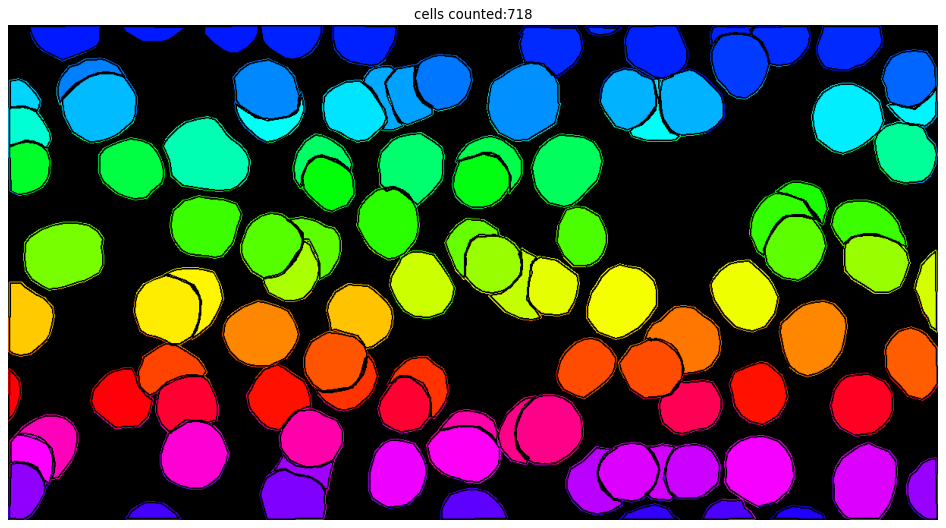

In [5]:
ret, labels = cv.connectedComponents(mask_edge)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0


print('cells number is:', ret-1)

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.axis("off")
ax.set_title('cells counted:'+ str(ret-1))
ax.imshow(labeled_img)

- here we try to extract each cell individually

count before denoise = 719
count after denoise = 105


105

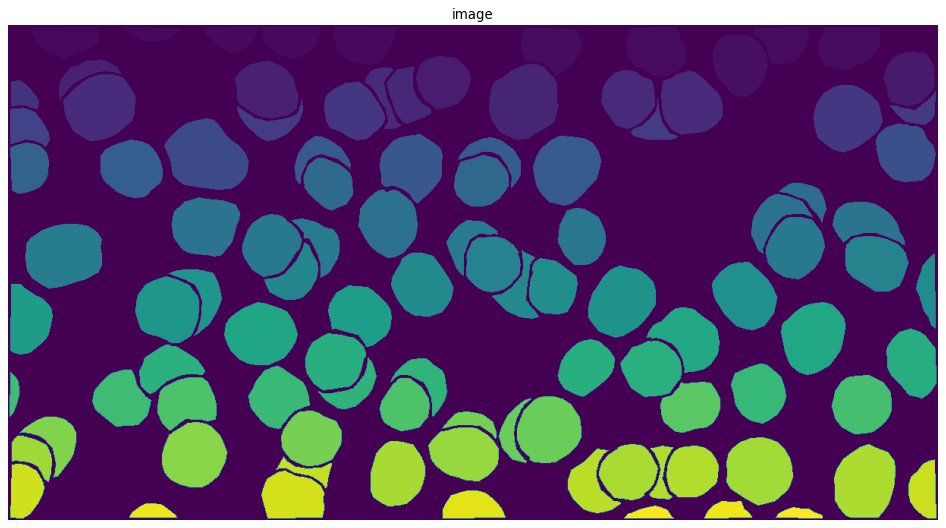

In [7]:
image_sample = mask_edge.copy()

print(f"count before denoise = {ret}")

image_sample = data.surfaceFilter(image_sample, min_size = 500, max_size= None, colorize = False)

data.showImg(image_sample)

print(f"count after denoise = {len(np.unique(image_sample))}")

polygon_list = data.make_polygon_lists(["data/test/Im037_0.json"])[0]
len(polygon_list)

- apply Countours Algorithm

In [8]:
import imutils

- Find contours with cv.findContours

[INFO] 104 unique contours found


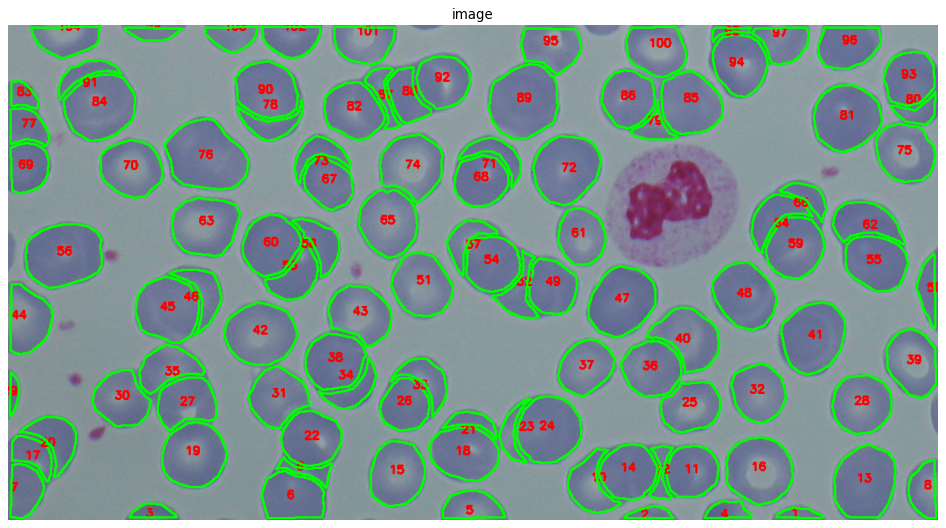

In [9]:
image_sample1 = data.surfaceFilter(mask_edge, min_size = 400, max_size= None, colorize = True, gray=True)

image_sample2 = image.copy()

contours = cv.findContours(image_sample1.copy(), cv.RETR_EXTERNAL,
	cv.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)
print("[INFO] {} unique contours found".format(len(contours)))

# loop over the contours
for (i, c) in enumerate(contours):
	# draw the contour
	((x, y), _) = cv.minEnclosingCircle(c)
	cv.putText(image_sample2, "{}".format(i + 1), (int(x) - 10, int(y)),
		cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
	cv.drawContours(image_sample2, [c], -1, (0, 255, 0), 2)
# show the output image
data.showImg(image_sample2)

- Apply Watershed Alogithm

In [10]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils

/tmp/ipykernel_115940/3835017534.py:15: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D,


[INFO] 98 unique segments found


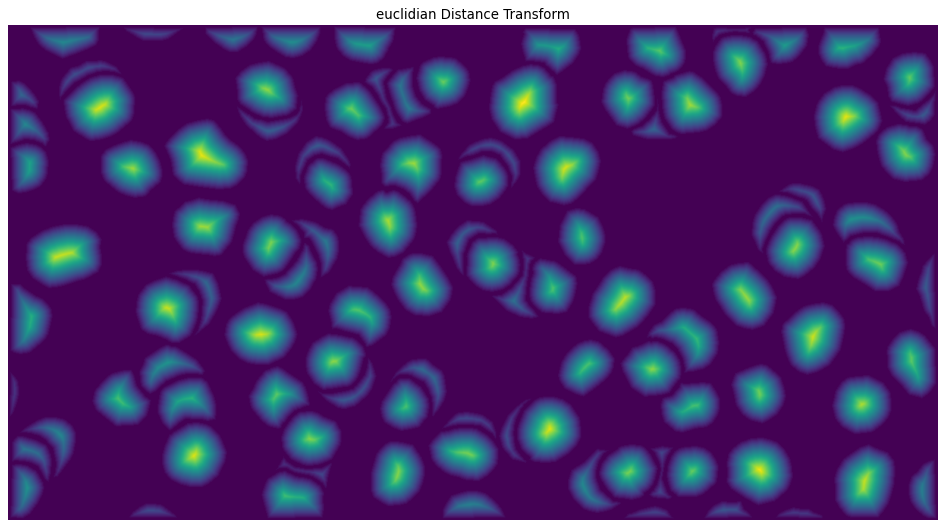

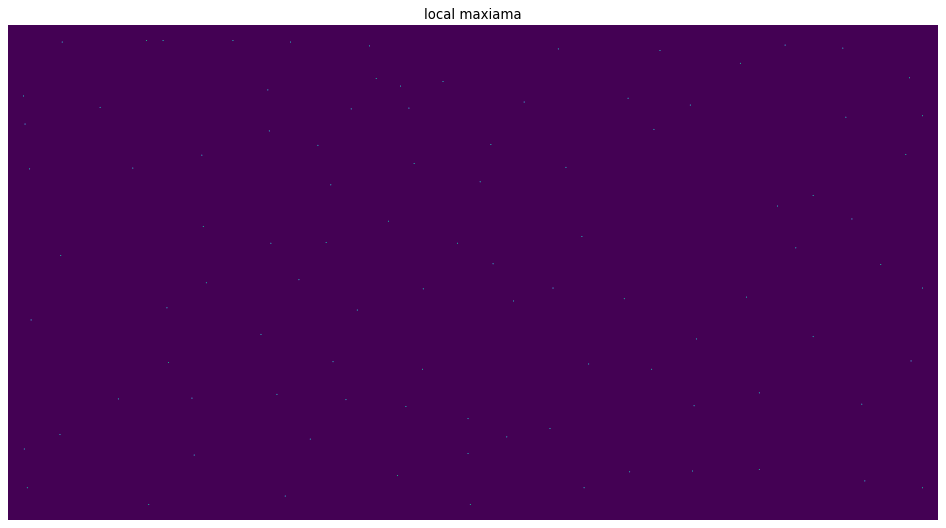

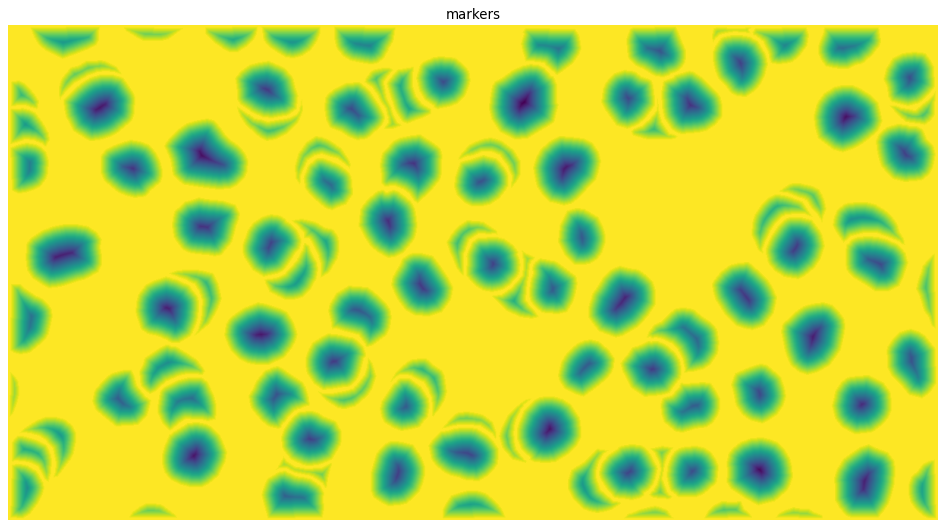

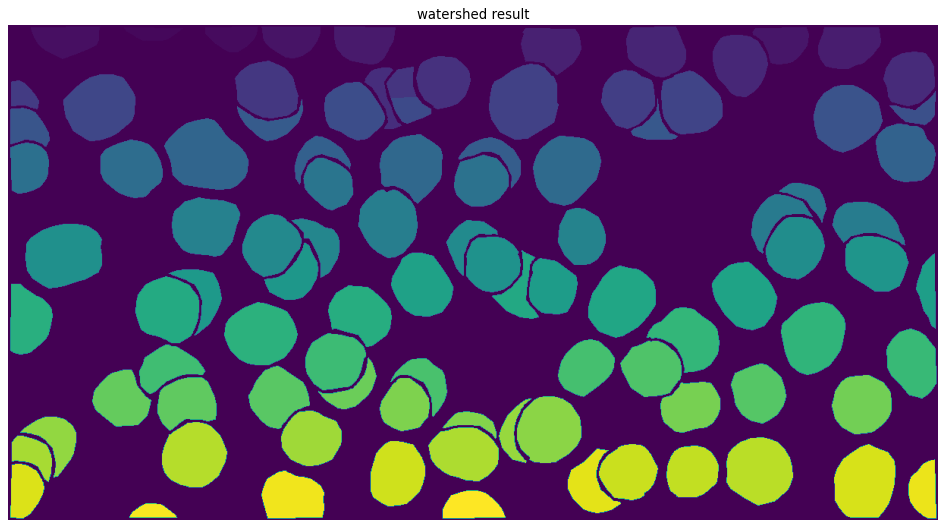

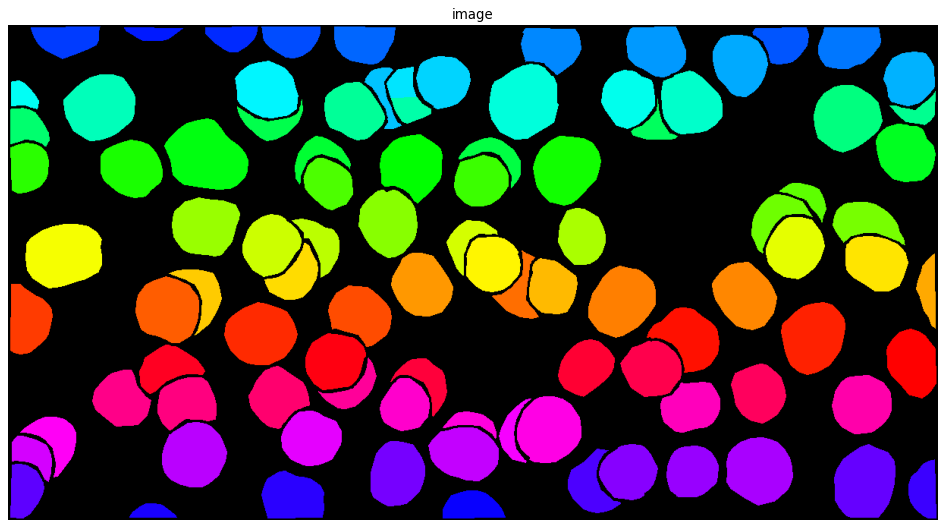

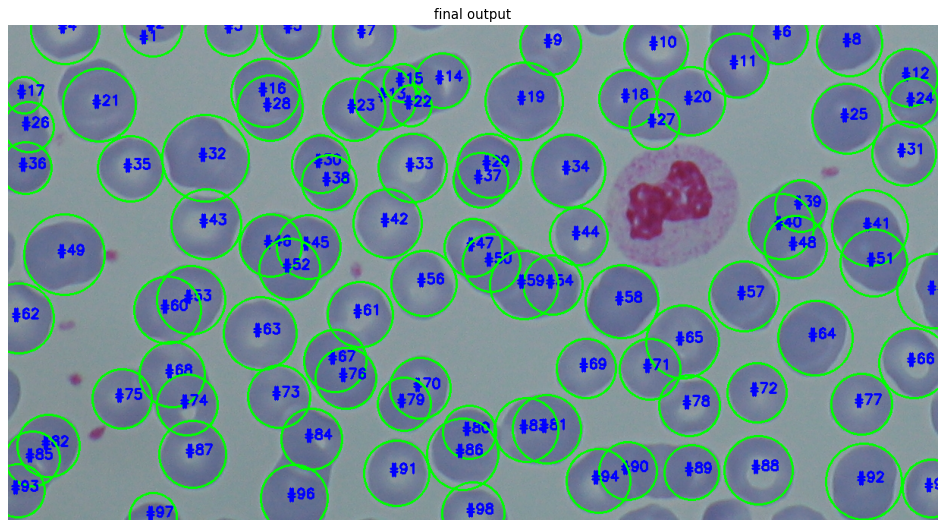

In [39]:
image_sample3 = data.surfaceFilter(mask_edge, min_size = 400, max_size= None, colorize = True, gray=True)

image_sample3 = ((image_sample3 > 0) * 255.0).astype(np.uint8)

D = ndimage.distance_transform_edt(image_sample3 > 0)

data.showImg(D, title="euclidian Distance Transform")

#DT = ndimage.morphology.distance_transform_cdt(image_sample3, metric="taxicab")

#showImg(DT, title="euclidian Distance Transform")


f = 25
localMax = peak_local_max(D, 
                          indices=False, 
                          min_distance=20, 
                          labels=image_sample3)
						  #footprint=np.ones((f, f)),
                          #threshold_abs = 15,
                          #threshold_rel = 0.2,
                          #num_peaks_per_label = 2)


data.showImg(localMax, "local maxiama")

# perform a connected component analysis on the local peaks to label each local maxima with a num,
# using 8-connectivity, then appy the Watershed algorithm we can also use connected component labeling
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]

#same image as local maxima
data.showImg(markers, title="markers")

labels = watershed(-D, markers, mask=image_sample3)

print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

data.showImg(labels, title="watershed result")

data.showImg(data.colorize_unique(labels))

#loop over the unique labels returned by the Watershed
# algorithm
image_orig = image.copy()
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(image_sample3.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,
		cv.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv.minEnclosingCircle(c)
	cv.circle(image_orig, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv.putText(image_orig, "#{}".format(label), (int(x) - 10, int(y)),
		cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
data.showImg(image_orig, title="final output")